# NDVI

The first index to calculate is the Normalized Difference Vegetation Index (NDVI).
It is an index that uses plant reflectivity in the infra-red spectrum and allows drawing conclusions on different plant types, vegetation health or surface condition.
It can be calculated from Sentinel-2 data using the red and infra-red spectra (bands 4 and 8):

$$
\text{NDVI} = \frac{\text{B08} - \text{B04}}{\text{B08} + \text{B04}}
$$

In [34]:
product_path

PosixPath('resources/tempelhofer_feld/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.zip')

In [30]:
import geopandas as gpd
from pathlib import Path
from sentinel_helpers import scihub_band_paths

base_path = Path('resources/tempelhofer_feld')
product_path = sorted(base_path.glob('*.zip'))[4]
output_path = base_path / 'ndvi'
output_path.mkdir(exist_ok=True, parents=True)

tempelhofer_feld = gpd.read_file(base_path / 'tempelhofer_feld.geojson')

b04_path, b08_path = scihub_band_paths(product_path, ['B04', 'B08'], '10m')
b04_path, b08_path

(PosixPath('zip+file:/home/jovyan/sources/resources/tempelhofer_feld/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.zip!/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.SAFE/GRANULE/L2A_T33UUU_A019939_20190417T102431/IMG_DATA/R10m/T33UUU_20190417T102031_B04_10m.jp2'),
 PosixPath('zip+file:/home/jovyan/sources/resources/tempelhofer_feld/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.zip!/S2A_MSIL2A_20190417T102031_N0211_R065_T33UUU_20190417T130913.SAFE/GRANULE/L2A_T33UUU_A019939_20190417T102431/IMG_DATA/R10m/T33UUU_20190417T102031_B08_10m.jp2'))

Because the indices get distorted by clouds, the cloud pixels have to be masked out.
The product downloads include a vector shape of areas in the product which likely represent clouds, from which a `shapely` polygon is constructed.

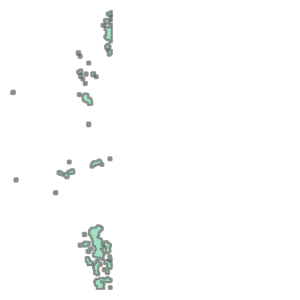

In [31]:
from sentinel_helpers import scihub_cloud_mask
cloud_mask = scihub_cloud_mask(product_path)
cloud_mask

The actual calculation can be expressed using `numpy` arrays thanks to operator overloading which implements [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html): For two arrays `array_a` and `array_b` with identical shapes, `array_a + array_b` adds each cell in `array_a` with the corresponding cell in `array_b`. `b04 + b08` therefore does a pixel-wise addition for each pixel in `b04` and `b08`.

The product, which is much larger than only the designated area of interest, is masked an cropped, and the index is calculated. The mask is modified so that cloud pixels are masked out as well.

CPU times: user 1.42 s, sys: 91.8 ms, total: 1.51 s
Wall time: 630 ms


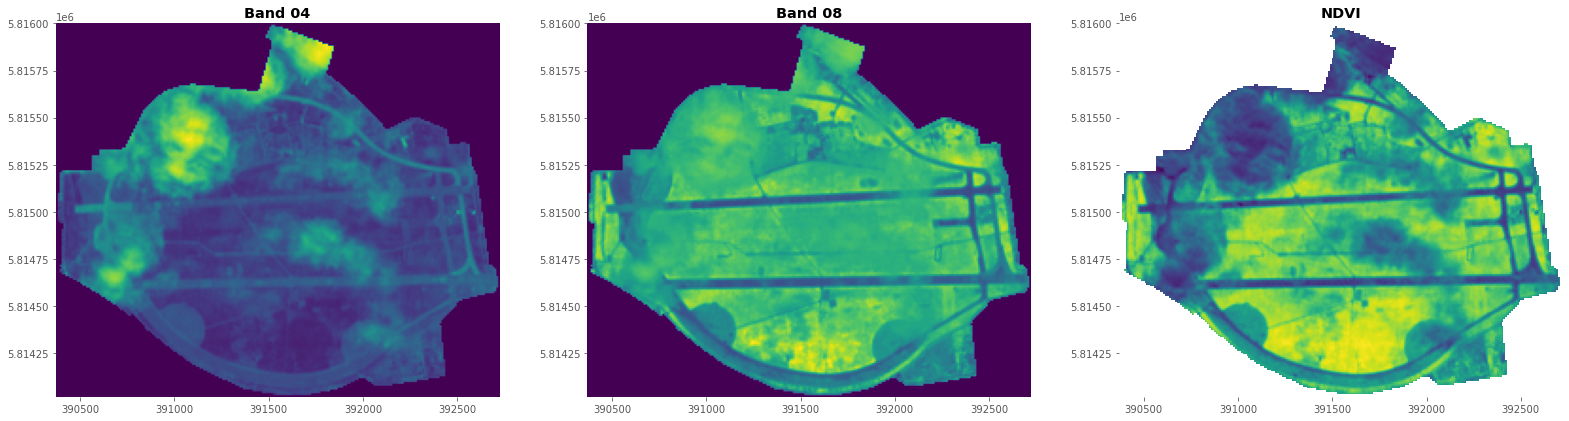

In [32]:
%%time

import matplotlib.pyplot as plt
import numpy as np
import rasterio as r
import rasterio.mask
import rasterio.plot as rplt

def normalize(v):
    '''
    Normalizes Sentinel-2 DN numbers to reflectance values ranging from 0 to 1
    and clips values outside of the allowed range.
    '''
    return (np.clip(v, 0, 10_000) / 10_000).astype('f4') # ← four-byte-float / float32

with r.open(b04_path, 'r') as b04, r.open(b08_path, 'r') as b08:
    # we want to only write the bare minimum data necessary to disk
    out_meta = b04.meta.copy()
    
    # we reproject the geojson file we fetched above and convert it so that rasterio
    # can use it as a mask; we subtract the cloud mask
    mask = (tempelhofer_feld.to_crs(out_meta['crs']).iloc[0].geometry - cloud_mask)
    miny, minx, maxy, maxx = mask.bounds
    
    # update the dimensions and save as geotiff, not jp2
    out_meta.update({
        'width': maxx - minx,
        'height': maxy - miny,
        'driver': 'GTiff',
        'dtype': 'float32'
    })    
    out_name = Path(b04_path).name.replace('B04', 'NDVI').replace('.jp2', '.tif')
    
    output_file = output_path / out_name
    with r.open(output_file, 'w+', **out_meta) as dst:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(27,9))
        
        # hide background grid in plot
        ax1.grid(False)
        ax2.grid(False)
        ax3.grid(False)
        
        # we take only the part out of our source raster that we actually need
        # crop=True clips off the borders
        b04, transform_b04 = rasterio.mask.mask(b04, shapes=[mask], crop=True)
        b08, _ = rasterio.mask.mask(b08, shapes=[mask], crop=True) # we ignore the returned transform because it's identical to the previous one

        b04 = normalize(b04)
        b08 = normalize(b08)
        
        # while unlikely to happen, we ignore divide by zero errors when they occur
        np.seterr(divide='ignore', invalid='ignore')
        ndvi = (b08 - b04) / (b08 + b04)
       
        # uncomment the following line to see if we calculated the index correctly
        rplt.show(b04, transform=transform_b04, ax=ax1, title='Band 04')
        rplt.show(b08, transform=transform_b04, ax=ax2, title='Band 08')
        rplt.show(ndvi, transform=transform_b04, ax=ax3, title='NDVI')
        
        dst.write(ndvi)

> Areas of barren rock, sand, or snow usually show very low NDVI values (for example, 0.1 or less). Sparse vegetation such as shrubs and grasslands or senescing crops may result in moderate NDVI values (approximately 0.2 to 0.5). High NDVI values (approximately 0.6 to 0.9) correspond to dense vegetation such as that found in temperate and tropical forests or crops at their peak growth stage. 

In [33]:
tempelhofer_feld.to_crs(out_meta['crs']).iloc[0].geometry + cloud_mask

TypeError: unsupported operand type(s) for +: 'Polygon' and 'MultiPolygon'